In [1]:
import importlib.util

package_name = 'trimesh'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install trimesh
else:
    print(package_name +" is installed")
    
package_name = 'mahotas'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install mahotas
else:
    print(package_name +" is installed")
    


trimesh is installed
mahotas is installed


In [2]:
import numpy as np
import math
import cv2
import os
import pandas as pd
import mahotas
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import regionprops
from skimage.transform import rescale, resize
from skimage.morphology import thin
from skimage.morphology import skeletonize
from skimage.morphology import medial_axis
from matplotlib.ticker import MultipleLocator
from utils import dataset_loader, my_utils, Operations, Moments, generate_point_cloud
import warnings
warnings.filterwarnings('ignore')

from plyfile import PlyData, PlyElement
from itertools import product, combinations 

In [3]:
%matplotlib inline

# 0 Normalize the point cloud

In [4]:
def calc_mue(M):
    """
     Args:
         M: point cloud
    returns mean of a point cloud
    """
    return np.mean(M, axis=0)

def calc_dist(p, mue): 
    """    
    At first, minus mue from point clouds, then calculate square 2 of them
     Args:
         p:   point cloud
         mue: mean of point cloud
    
    returns: calculated distance
    """
    return np.linalg.norm(p-mue, 2)

def norm_points(DATA, do_normalize):
    processed_points = []      
    points  = DATA
    confidence = 0.95

    if do_normalize:
        Inlaier_points = []
        mue            = calc_mue(points)# cal mean of a point cloud
    #     print(mue.shape)
    #     print('mue', mue)
        sorted_dists   = sorted([calc_dist(p, mue) for p in points])
        XY             = [(0, 0)]
        t              = len(sorted_dists)
        for j, d in enumerate(sorted_dists):
            XY.append(( d, 1.*j/t ))
            if 1.*j/t >= confidence:
                break
        sorted_idx     = sorted([(i, my_utils.calc_dist(p, mue)) for i, p in enumerate(points)], key= lambda d:(d[1], d[0]))
        inlaier        = [d[0] for d in sorted_idx[:j]]
        inlaier_points = [points[j] for j in inlaier]
        points         = np.array(inlaier_points)
    #     print(points.shape)
        points        -= mue
    
    return points

## 1.1 Load .3d files

In [5]:
DATA_DIR    = 'D:\\forClone\\Hiwi\\results_mtemp_hilo'
sample_inx = 1
tmp_inx = 2
sample_file = 'sample_'+str(sample_inx)+'_go'+str(tmp_inx)+".3d"
sample_pth = os.path.join(DATA_DIR, sample_file)
print(sample_pth)

D:\forClone\Hiwi\results_mtemp_hilo\sample_1_go2.3d


In [6]:
file = os.path.join(sample_pth)
print(file)

D:\forClone\Hiwi\results_mtemp_hilo\sample_1_go2.3d


### If .ply files

In [ ]:
import open3d as o3d

pcd_load = o3d.io.read_point_cloud(sample_pth)
# o3d.visualization.draw_geometries([pcd_load])
# convert Open3D.o3d.geometry.PointCloud to numpy array
DATA = np.asarray(pcd_load.points)
DATA = DATA.astype(np.float)
print(type(DATA))
print(DATA.size)
do_normalize = True
DATA = norm_points(DATA, do_normalize)
print(type(DATA))
print(DATA.size)

### if .3d files

In [9]:
DATA = pd.read_csv(file, delimiter = "\t", header=None)
DATA = DATA.to_numpy()[:,:3]#only extract the location information
DATA[:,2] = 1-DATA[:,2]
print(type(DATA))
print(DATA.size)
DATA = DATA.astype(np.float)
do_normalize = True
DATA = norm_points(DATA, do_normalize)
print(type(DATA))
print(DATA.size)

<class 'numpy.ndarray'>
7863


<class 'numpy.ndarray'>
7470


## 1.2 Try Open3D

In [11]:
import open3d as o3d

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(DATA)
o3d.io.write_point_cloud("DATA.ply", pcd)
# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("DATA.ply")
o3d.visualization.draw_geometries([pcd_load])
# convert Open3D.o3d.geometry.PointCloud to numpy array
xyz_load = np.asarray(pcd_load.points)
print('xyz_load')
print(xyz_load)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
xyz_load
[[ 0.00887897  0.00442712  0.01069265]
 [-0.01603353  0.02712354 -0.0084268 ]
 [-0.0236514  -0.0180753  -0.01421526]
 ...
 [-0.2865709  -0.34048073 -0.05157713]
 [-0.14739033  0.20112935 -0.37239804]
 [ 0.26006283 -0.28926832 -0.22312598]]


In [11]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(DATA)
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)
# for alpha in np.logspace(np.log10(0.5), np.log10(0.01), num=4):
alpha = 0.5
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    pcd, alpha, tetra_mesh, pt_map)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

alpha=0.500


# 2 Try Original matlibplot

In [10]:
DATA_DIR    = 'D:\\forClone\\Hiwi\\results_mtemp_hilo'
sample_inx = 2
tmp_inx = 2
sample_file = 'sample_'+str(sample_inx)+'_go'+str(tmp_inx)+".3d"
sample_pth = os.path.join(DATA_DIR, sample_file)
info_file = 'sample_'+str(sample_inx)+'info'+str(tmp_inx)+".3d"
info_pth = os.path.join(DATA_DIR, info_file)

sample_file = os.path.join(sample_pth)
info_file = os.path.join(info_pth)
print(sample_file)
print(info_file)
DATA = pd.read_csv(sample_file, delimiter = "\t", header=None)
INFO = pd.read_csv(info_file, delimiter = "\t", header=None)

print(DATA.size)
print(INFO)
DATA = DATA.to_numpy()[:,:3]#only extract the location information
INFO = INFO.to_numpy()
DATA  = DATA  * (INFO[1,:]-INFO[2,:]) + INFO[2,:]+ INFO[0,:];
DATA[:,2] = 1-DATA[:,2]
print(type(DATA))
print(DATA.size)

DATA = DATA.astype(np.float)
do_normalize = True
DATA = norm_points(DATA, do_normalize)
print(type(DATA))
print(DATA.size)
# dataset_dict[surf] = DATA

D:\forClone\Hiwi\results_mtemp_hilo\sample_2_go2.3d
D:\forClone\Hiwi\results_mtemp_hilo\sample_2info2.3d
7275
              0            1           2
0  20943.119835  7315.255629  170.821732
1  21202.900000  7574.700000  483.700000
2  20699.100000  7065.300000  -90.600000
<class 'numpy.ndarray'>
7275
<class 'numpy.ndarray'>
6912


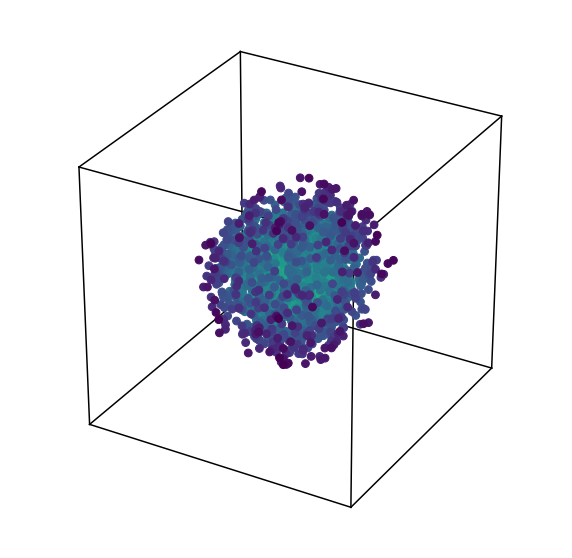

In [11]:
from itertools import product, combinations 
# https://stackoverflow.com/questions/15053575/python-3d-scatterplot-colormap-issue
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#sphx-glr-tutorials-colors-colorbar-only-py
colors = ['g', 'b', 'k', 'y', 'm', 'c']
points = DATA
#     print(dataset_dict)
sample_per_class = 1
mue            = np.mean(DATA, axis=0)

dists   = [calc_dist(p, mue) for p in points]

dists = np.array(dists)
abs_dists = np.abs(dists)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, sample_per_class, 1, projection="3d")
cmap = mpl.cm.viridis
# https://www.geeksforgeeks.org/how-to-reverse-a-colormap-using-matplotlib-in-python/
cmap = cmap.reversed()
# cmap_norm =  mpl.colors.Normalize(vmin=0, vmax=0.45)
# ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=colors[1],marker="o", facecolor="red", lw=0, alpha=1)
ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=abs_dists,cmap=cmap, alpha=1)
ax1.scatter(mue[0], mue[1], mue[2], s=200, c='r', marker="*")
ax1.set_xlabel('x / nm')
ax1.set_ylabel('y / nm')
ax1.set_zlabel('z / nm')
ax1.set_xlim((-350,350))
ax1.set_ylim((-350,350))
ax1.set_zlim((-350,350))

# draw cube
r = [-350, 350]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
   if np.sum(np.abs(s-e)) == r[1]-r[0]:
      ax1.plot3D(*zip(s, e), color="k")

ax1.grid(False)
ax1.axis('off')
# ax1.set_title('35C', fontsize=30)
plt.show()

# 3 Multiple temperatures

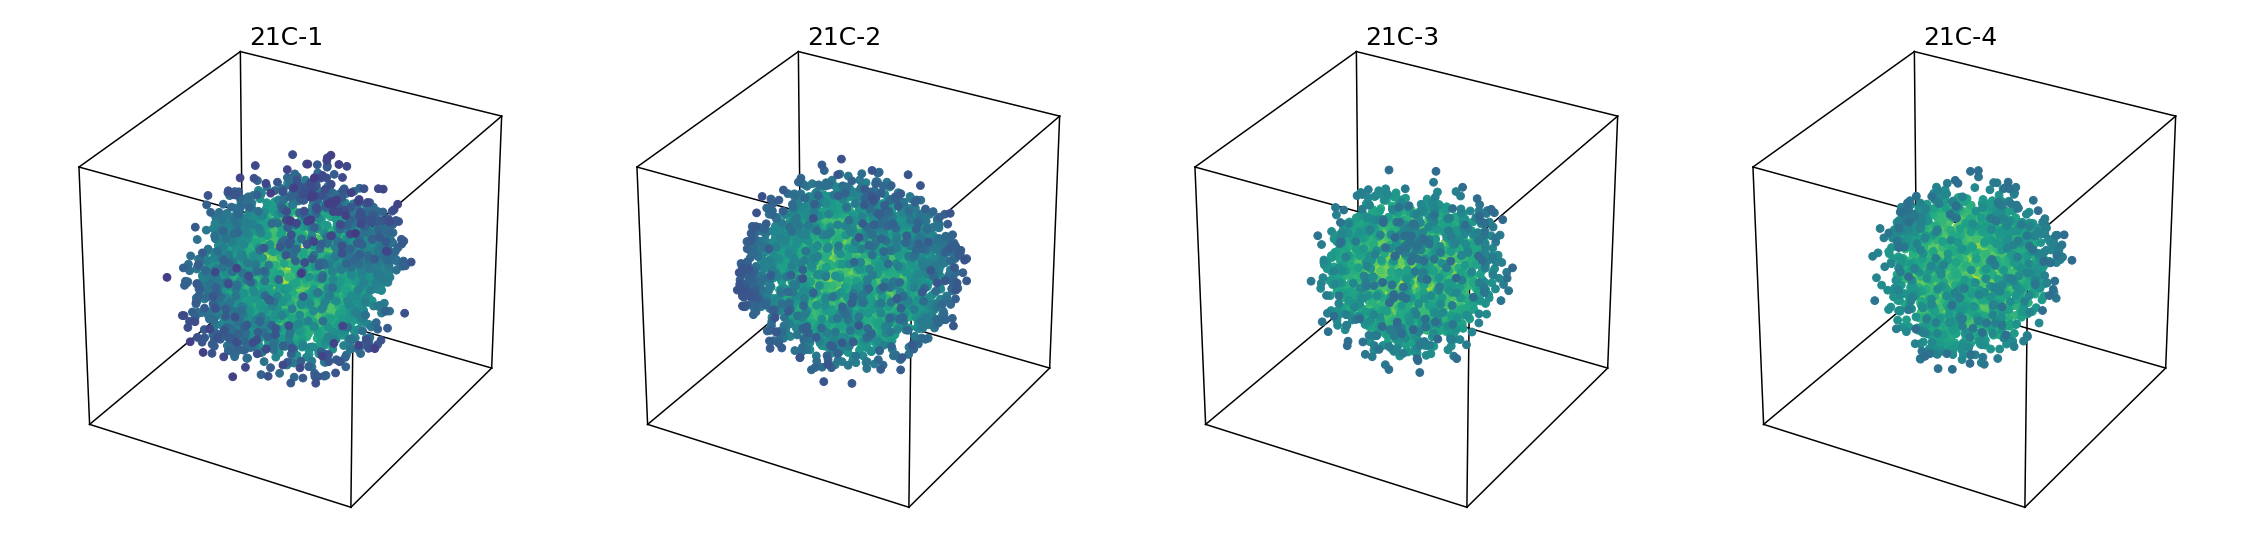

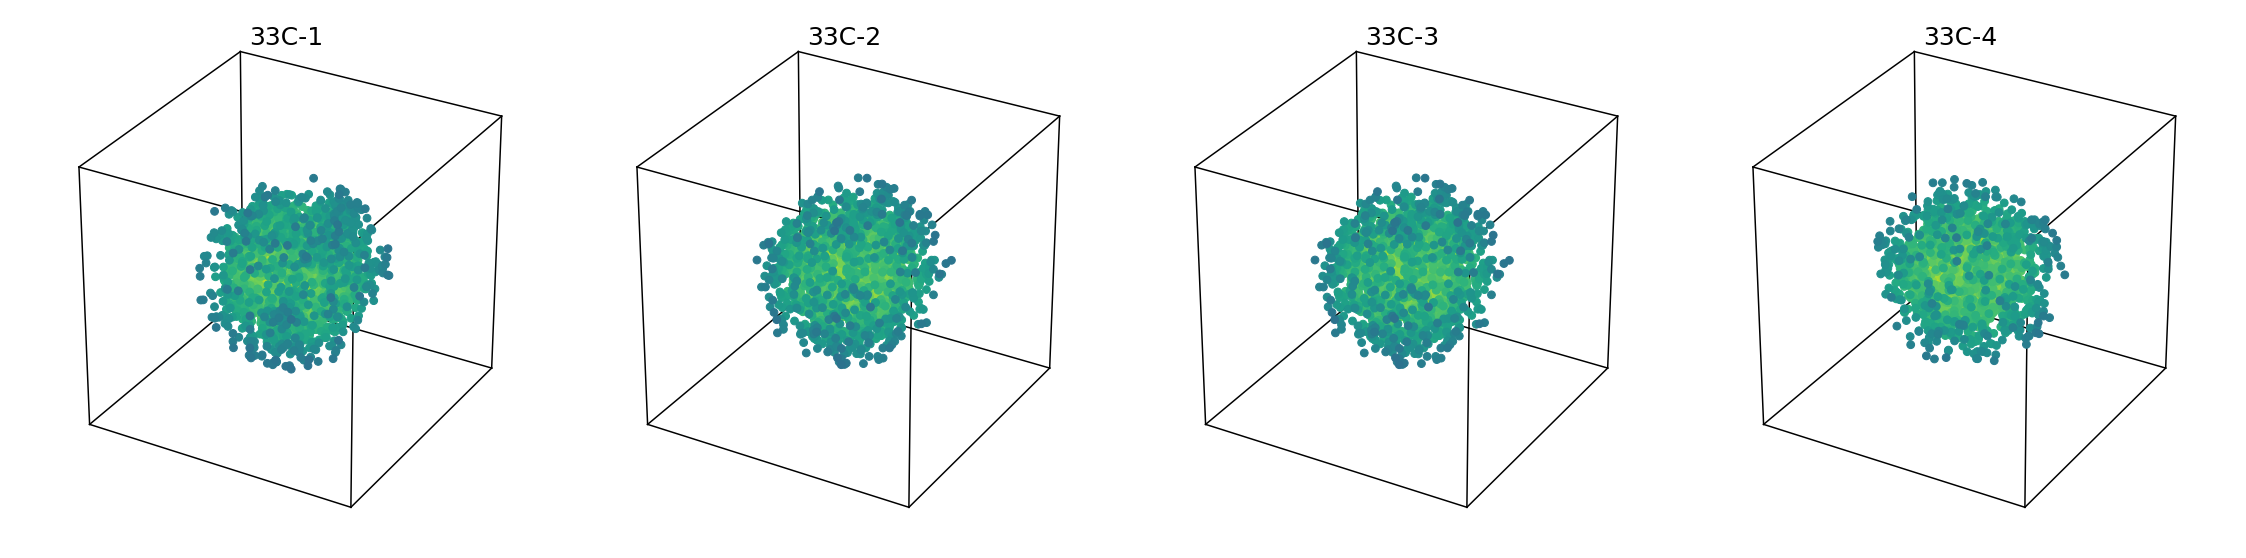

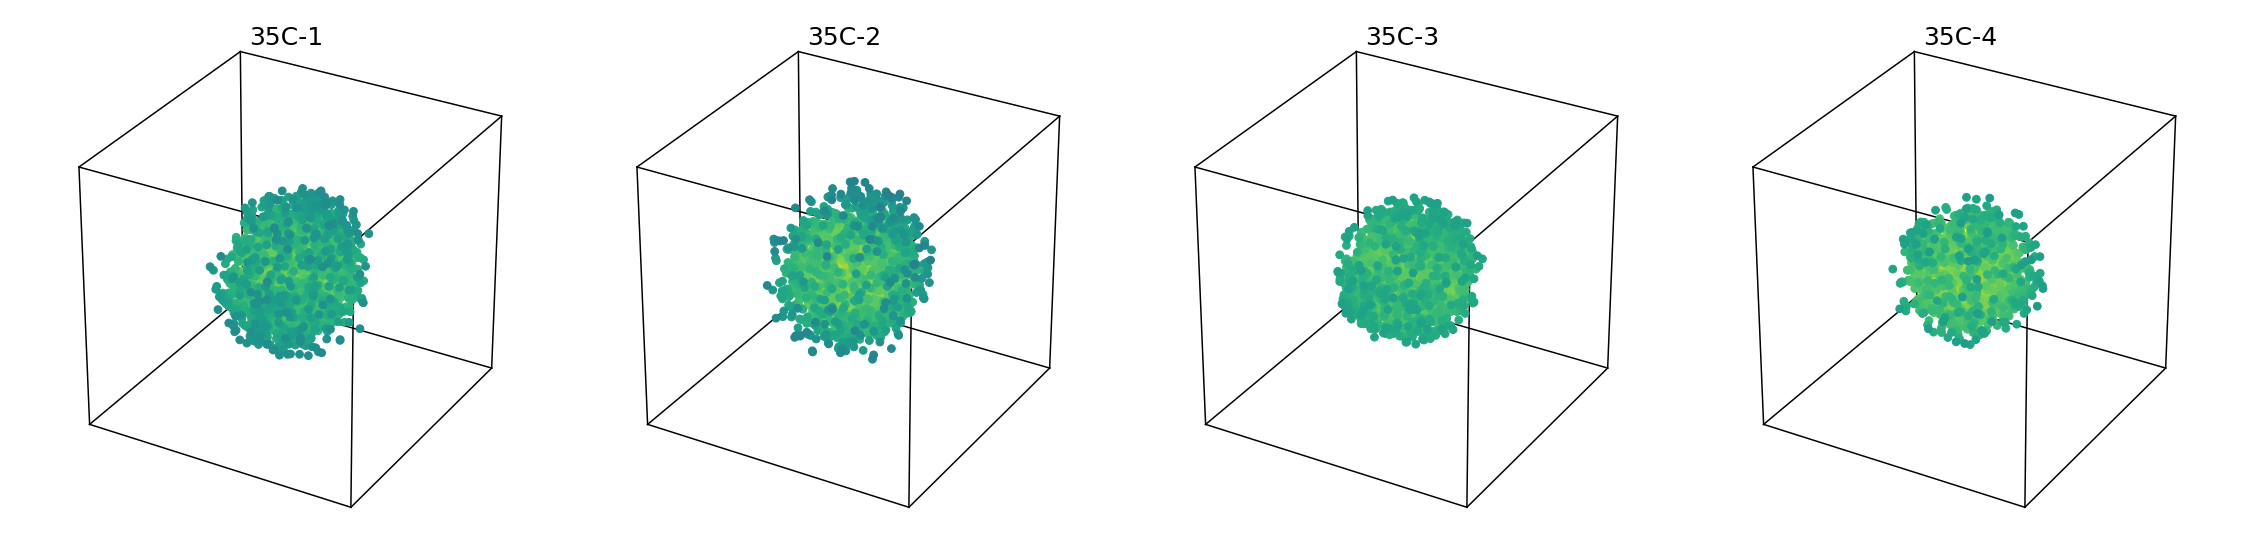

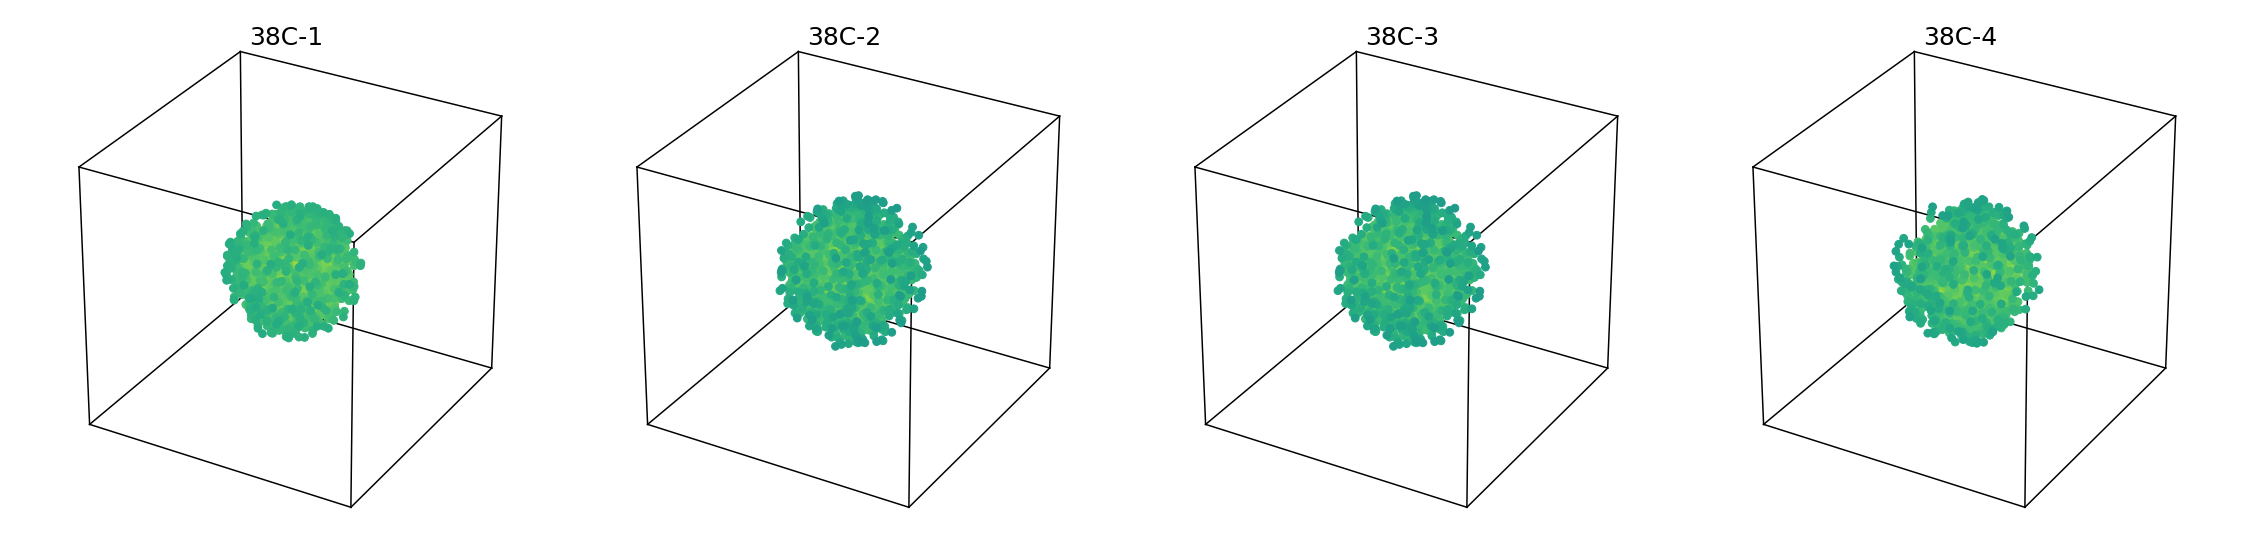

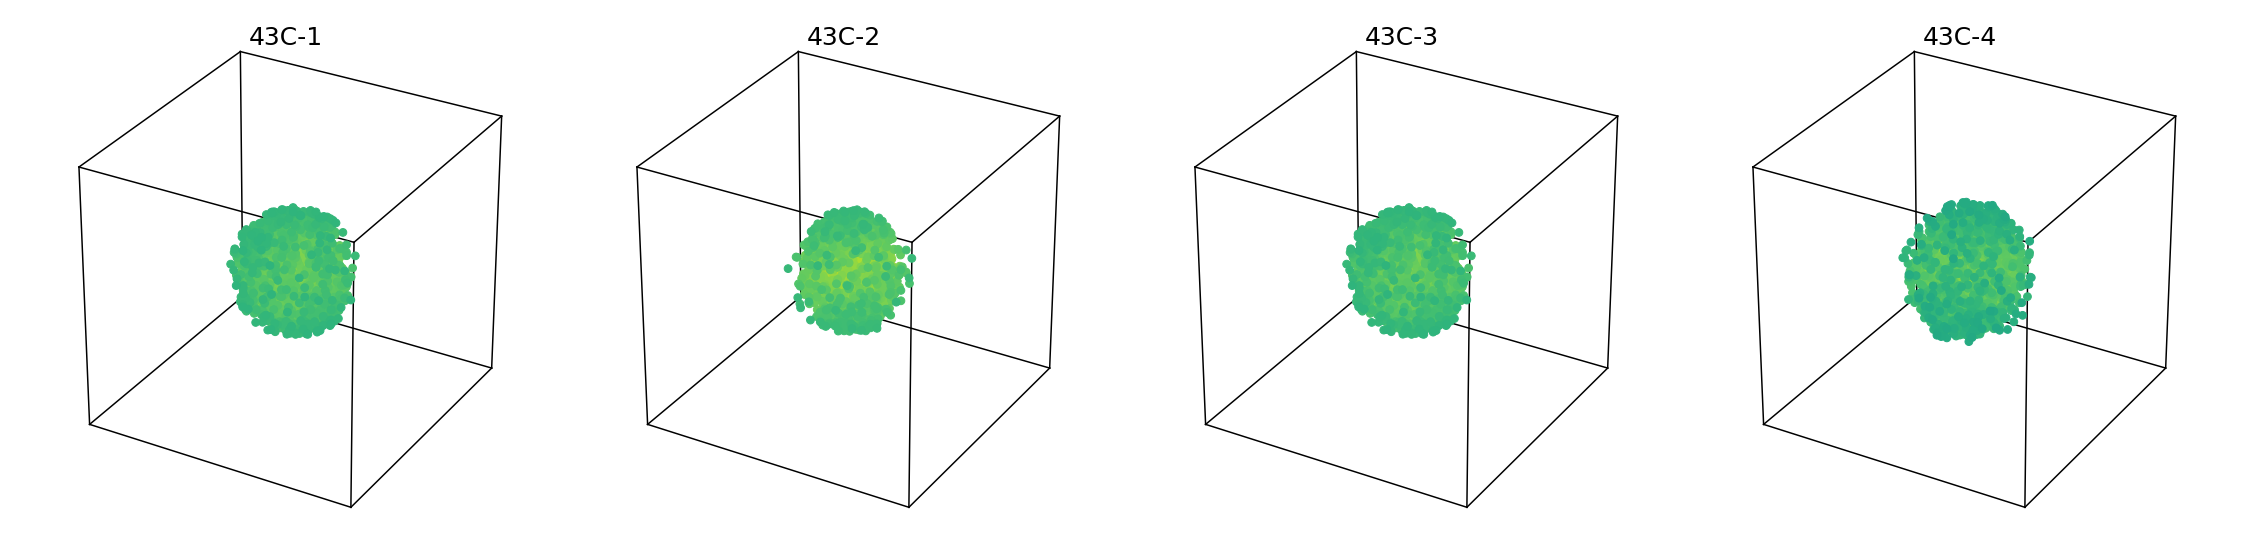

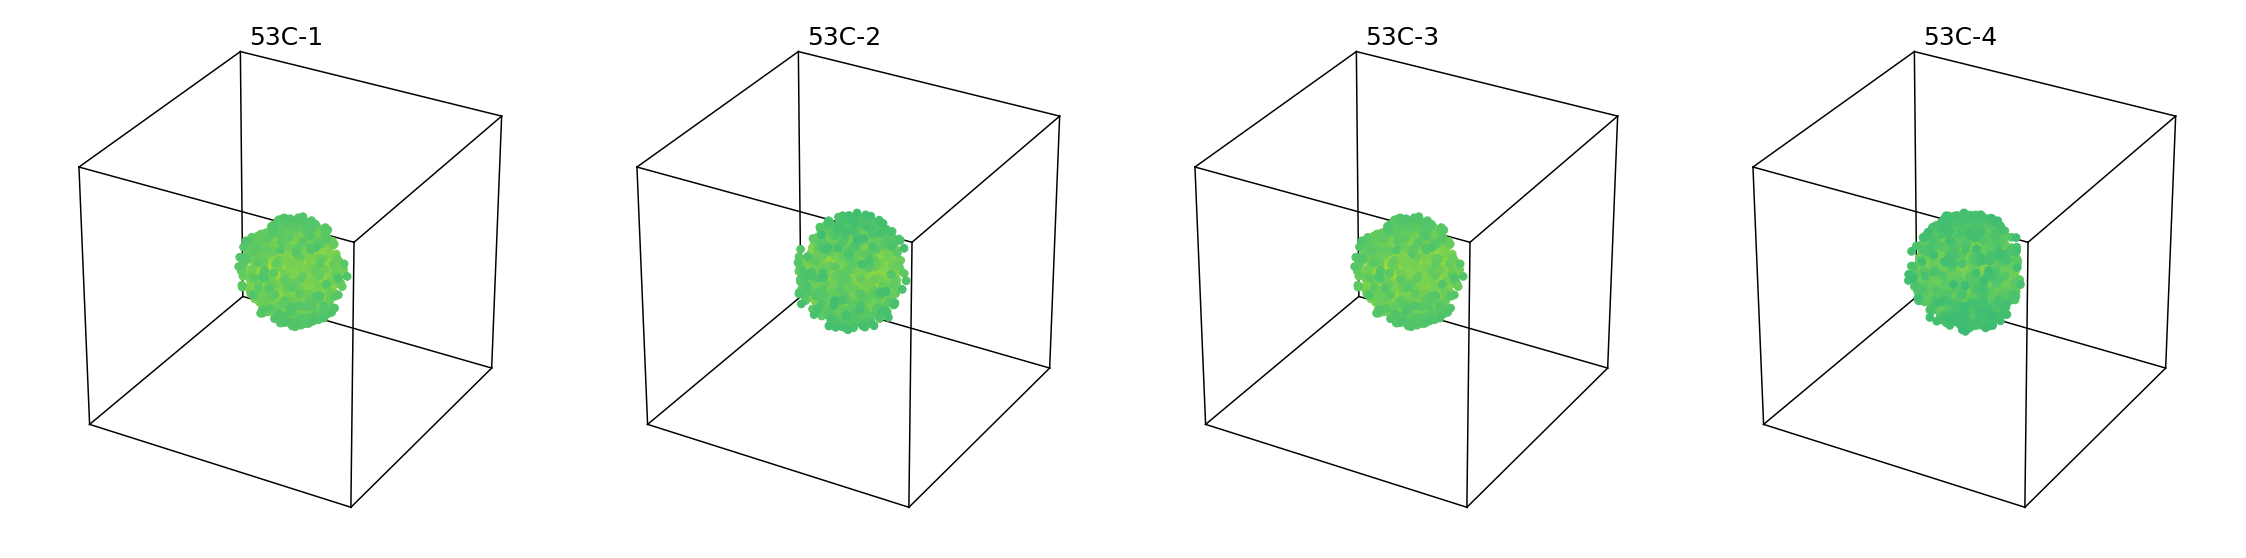

In [20]:

# https://stackoverflow.com/questions/15053575/python-3d-scatterplot-colormap-issue
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#sphx-glr-tutorials-colors-colorbar-only-py
DATA_DIR    = 'D:\\forClone\\Hiwi\\results_mtemp_hilo'
data_type = '_go' #'_go' or 'gg'
for tmp_inx in range(1,7):
     # tmp_inx = 2 

    if tmp_inx == 1:
            tmp_info = '21C'
    elif tmp_inx == 2:
        tmp_info = '33C'
    elif tmp_inx == 3:
        tmp_info = '35C'
    elif tmp_inx == 4:
        tmp_info = '38C'
    elif tmp_inx == 5:
        tmp_info = '43C'
    else:
        tmp_info = '53C'

    fig = plt.figure(figsize=(40,10))
    for sample_inx in range(1,5):
        # sample_inx = 1
        sample_file = 'sample_'+str(sample_inx)+data_type+str(tmp_inx)
        sample_pth = os.path.join(DATA_DIR, sample_file+'.3d')
        info_file = 'sample_'+str(sample_inx)+'info'+str(tmp_inx)+".3d"
        info_pth = os.path.join(DATA_DIR, info_file)

        sample_file = os.path.join(sample_pth)
        info_file = os.path.join(info_pth)
#         print(sample_file)
#         print(info_file)
        DATA = pd.read_csv(sample_file, delimiter = "\t", header=None)
        INFO = pd.read_csv(info_file, delimiter = "\t", header=None)

#         print(DATA.size)
#         print(INFO)
        DATA = DATA.to_numpy()[:,:3]#only extract the location information
        INFO = INFO.to_numpy()
        DATA  = DATA  * (INFO[1,:]-INFO[2,:]) + INFO[2,:]+ INFO[0,:];
        DATA[:,2] = 1-DATA[:,2]
#         print(type(DATA))
#         print(DATA.size)

        DATA = DATA.astype(np.float)
        do_normalize = True
        DATA = norm_points(DATA, do_normalize)
#         print(type(DATA))
#         print(DATA.size)

        colors = ['g', 'b', 'k', 'y', 'm', 'c']
        points = DATA
        #     print(dataset_dict)
        sample_per_class = 1
        mue            = np.mean(DATA, axis=0)

        dists   = [calc_dist(p, mue) for p in points]

        dists = np.array(dists)
        abs_dists = np.abs(dists)
        ax1 = fig.add_subplot(1, 4, sample_inx, projection="3d")
        cmap = mpl.cm.viridis
        # https://www.geeksforgeeks.org/how-to-reverse-a-colormap-using-matplotlib-in-python/
        cmap = cmap.reversed()
        # cmap_norm =  mpl.colors.Normalize(vmin=0, vmax=0.45)
        # ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=colors[1],marker="o", facecolor="red", lw=0, alpha=1)
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=abs_dists,vmax=350, vmin=50, cmap=cmap, alpha=1)
        ax1.scatter(mue[0], mue[1], mue[2], s=200, c='r', marker="*")
        ax1.set_xlabel('x / nm')
        ax1.set_ylabel('y / nm')
        ax1.set_zlabel('z / nm')
        ax1.set_xlim((-350,350))
        ax1.set_ylim((-350,350))
        ax1.set_zlim((-350,350))

        # draw cube
        r = [-350, 350]
        for s, e in combinations(np.array(list(product(r, r, r))), 2):
           if np.sum(np.abs(s-e)) == r[1]-r[0]:
              ax1.plot3D(*zip(s, e), color="k")

        ax1.grid(False)
        ax1.axis('off')
        title_info = tmp_info+'-'+str(sample_inx)
        ax1.set_title(title_info, fontsize=25)
    
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()
    fig.savefig('D:\\forClone\\Hiwi\\results_mtemp_hilo_ply\\'+'3d_'+data_type+tmp_info+'.pdf', bbox_inches='tight')

# 4 Save normalized ply

In [40]:
import open3d as o3d
# https://stackoverflow.com/questions/15053575/python-3d-scatterplot-colormap-issue
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#sphx-glr-tutorials-colors-colorbar-only-py
DATA_DIR    = 'D:\\forClone\\Hiwi\\results_mtemp_hilo'

for sample_inx in range(1,5):
# sample_inx = 1
    for tmp_inx in range(1,7):
    # tmp_inx = 2
        if tmp_inx == 1:
            tmp_info = '21C'
        elif tmp_inx == 2:
            tmp_info = '33C'
        elif tmp_inx == 3:
            tmp_info = '35C'
        elif tmp_inx == 4:
            tmp_info = '38C'
        elif tmp_inx == 5:
            tmp_info = '43C'
        else:
            tmp_info = '53C'
        sample_nm = 'sample_'+str(sample_inx)+'gg'+str(tmp_inx)
        sample_file = sample_nm+'.3d'
        sample_pth = os.path.join(DATA_DIR, sample_file)
        info_file = 'sample_'+str(sample_inx)+'info'+str(tmp_inx)+".3d"
        info_pth = os.path.join(DATA_DIR, info_file)

        sample_file = os.path.join(sample_pth)
        info_file = os.path.join(info_pth)
        DATA = pd.read_csv(sample_file, delimiter = "\t", header=None)
        INFO = pd.read_csv(info_file, delimiter = "\t", header=None) 
        DATA = DATA.to_numpy()[:,:3]#only extract the location information
        INFO = INFO.to_numpy()
        DATA  = DATA  * (INFO[1,:]-INFO[2,:]) + INFO[2,:]+ INFO[0,:];
        DATA[:,2] = 1-DATA[:,2]

        DATA = DATA.astype(np.float)
        do_normalize = True
        DATA = norm_points(DATA, do_normalize)
        
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(DATA)
        o3d.io.write_point_cloud("D:\\forClone\\Hiwi\\results_mtemp_hilo_ply\\"+sample_nm+".ply", pcd)
        
    
